# Análisis de Reviews de compras con NLP

Consideramos los datos de opiniones de usuarios en los siguientes productos: automóviles, hoteles, lavadoras, libros,
teléfonos celulares, música, computadoras y pelı́culas(400 opiniones). Para
el sentimiento tenemos dos categorias: yes y no, que indican las opiniones positivas
y negativas, respectı́vamente. Clasificaremos los sentimientos usando algunos métodos de clasificación.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')

✘ No compatible model found for 'en_core_news_sm' (spaCy v2.2.4).



In [ ]:
from os import walk
from my_functions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC # Support vector classifier


# Obteniendo una representación vectorial de los textos mediante Bag Of Words (BOW)

## creando un corpus

In [ ]:
pwd

'/content'

In [ ]:
mypath = "/content/drive/MyDrive/Colab_Notebooks/all_files/"
_, _, filenames = next(walk(mypath))
filenames.sort()

In [ ]:
archivos= [open(mypath+filename, "r", encoding="latin-1") for filename in filenames]
corpus = [archivo.read() for archivo in archivos]
corpus[0]

'Me compre este coche en el 2000.No lo he utilizado mucho.Actualmente (agosto 2002) tiene 22.800 km.Con solo 22.000,averia del embrague 70.000 ptas.Que dice Seat at.cliente? ha pasado la garantia no se hacen cargo,a pesar,que el mecanico me dijo que NO se debia a mal uso por mi parte.Lo arreglo.Resulta que el pedal,una vez arreglado,no sube del todo.Me lo vuelven a arreglar y actualmente sigue mal.Tiene ujnh ruido en los bajos que parece un concierto.No m atrevo a viajar de vacaciones con el.Muy normal con un coche de 20 años pero con este de 22.000 km? de risa.Eso si,asimila el aceite q es una maravilla!!! 6 litros hasta hoy.Ahoira llevo 2 meses sin mirar el deposito y estara por la mitad calculo yo.Una ganga este coche!!! Mantenerlo sale a precio d Audi.Ideal para gente joven.Gracias (bap_555@hotmail.com) '

## Preprocesando el corpus

In [ ]:
preprocesador = preprocesaTexto(idioma='es', _tokeniza=False, _muestraCambios=False, _quitarAcentos=True, _quitarNumeros=True,
                                _remueveStop=True, _stemming=False, _lematiza=True, _removerPuntuacion=True)

In [ ]:
preprocesador.preprocesa(corpus[0])

'compre coche utilizado muchoactualmente agosto kmcon solo averia embrague ptasque dice seat atcliente pasado garantia hacen cargoa pesarque mecanico dijo debia mal uso partelo arregloresulta pedaluna vez arregladono sube todome vuelven arreglar actualmente sigue maltiene ujnh ruido bajos parece conciertono m atrevo viajar vacacione elmuy normal coche años km risaeso siasimila aceite q maravilla litros hoyahoira llevo meses mirar deposito estara mitad calculo youna ganga coche mantenerlo sale precio d audiideal gente jovengracias baphotmailcom '

In [ ]:
corpus_prep = [preprocesador.preprocesa(txt) for txt in corpus]

In [ ]:
corpus_prep[0]

'compre coche utilizado muchoactualmente agosto kmcon solo averia embrague ptasque dice seat atcliente pasado garantia hacen cargoa pesarque mecanico dijo debia mal uso partelo arregloresulta pedaluna vez arregladono sube todome vuelven arreglar actualmente sigue maltiene ujnh ruido bajos parece conciertono m atrevo viajar vacacione elmuy normal coche años km risaeso siasimila aceite q maravilla litros hoyahoira llevo meses mirar deposito estara mitad calculo youna ganga coche mantenerlo sale precio d audiideal gente jovengracias baphotmailcom '

## BOW

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=10000)
X = vectorizer.fit_transform(corpus_prep)
bow = X.toarray()
bow_estandar = StandardScaler().fit_transform(bow) 
bow_df = pd.DataFrame(bow,columns=vectorizer.get_feature_names())
bow_df.head()

,aaron,abajo,abandona,abandonado,abandonar,abandono,abarcan,abate,abatir,abierta,abiertas,abierto,abiertos,abogada,aborrecer,abortar,abra,abre,abren,abria,abril,abrir,abrirlo,abs,absoluta,absolutamente,absoluto,absurda,absurdas,absurdez,absurdo,abuela,abuelita,abuelo,abundante,aburre,aburrida,aburrido,aburrir,aburrirme,...,yunfat,yuppie,yuque,yuyu,yve,zafarse,zafia,zafias,zafio,zafira,zancadas,zanussi,zanuzzi,zapato,zapatos,zara,zaragoza,zare,zeitgeis,zeitgeist,zen,zeppelin,zi,ziggetyzag,ziggy,zimmer,ziskin,zo,zombie,zomby,zona,zonas,zoom,zumbido,zumo,zumos,zwan,ñoña,ñoñas,ñoño
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Dado que hay mucha información irrelevante, tomamos la más representativa. Nos quedamos con las palabras que tienen por lo menos 3 concurrencias en los 400 textos.

In [ ]:
frecuencias_por_palabra = bow_df.sum(axis=0)
frecuencias_por_palabra[frecuencias_por_palabra>5]

abajo        16
abandonar     6
abierta       7
abierto       9
abre         11
             ..
yendo         6
york         22
zapatos       7
zeitgeist     9
zona         39
Length: 2879, dtype: int64

In [ ]:
palabras_relevantes = list(frecuencias_por_palabra[frecuencias_por_palabra>6].index)
palabras_relevantes

['abajo',
 'abierta',
 'abierto',
 'abre',
 'abrir',
 'absolutamente',
 'absoluto',
 'absurda',
 'absurdo',
 'abuela',
 'abuelita',
 'aburre',
 'aburrida',
 'aburrido',
 'acaba',
 'acabado',
 'acaban',
 'acabar',
 'acabe',
 'acabo',
 'acaso',
 'acceder',
 'acceso',
 'accesorio',
 'accidente',
 'accion',
 'ace',
 'aceite',
 'acepta',
 'aceptable',
 'aceptar',
 'acer',
 'acerca',
 'acero',
 'aclarado',
 'acompaña',
 'acompañado',
 'acondicionado',
 'aconsejo',
 'acorde',
 'acostumbrados',
 'actor',
 'actore',
 'actriz',
 'actuacion',
 'actual',
 'actualmente',
 'actuar',
 'acuerdo',
 'adam',
 'adaptacion',
 'adecuado',
 'adelante',
 'ademas',
 'adolescente',
 'adulto',
 'aeg',
 'aeropuerto',
 'agenda',
 'agradable',
 'agua',
 'ah',
 'ahi',
 'ahora',
 'ahorrar',
 'airbag',
 'aire',
 'ajena',
 'alarma',
 'album',
 'alcanzar',
 'alegria',
 'alejado',
 'aleman',
 'alguien',
 'algun',
 'alguna',
 'alguno',
 'alla',
 'allen',
 'alli',
 'alma',
 'alrededor',
 'alta',
 'altavoce',
 'altavoz',
 '

# Identificando disimilaridad en los textos con la disimilaridad del coseno

In [ ]:
# redefinimos la BOW
bow = bow_df[palabras_relevantes]
cos_sim = cosine_similarity(bow, bow)
sim_df = pd.DataFrame(cos_sim)
sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,1.000000,0.277635,0.253673,0.332779,0.280552,0.304335,0.198658,0.230956,0.253266,0.073898,0.379434,0.472360,0.238095,0.247076,0.330719,0.273388,0.184428,0.323502,0.337408,0.257172,0.128698,0.198471,0.258841,0.103457,0.109971,0.192879,0.325077,0.218218,0.246718,0.057864,0.064820,0.219873,0.223298,0.263963,0.177999,0.198471,0.185577,0.269771,0.333738,0.085724,...,0.029117,0.061644,0.034173,0.038432,0.000000,0.063719,0.047234,0.053121,0.040831,0.032410,0.043959,0.076680,0.070593,0.061314,0.093733,0.035098,0.055572,0.069418,0.016737,0.042593,0.032306,0.049471,0.053326,0.049249,0.049935,0.065542,0.030503,0.061454,0.059328,0.026963,0.073985,0.000000,0.037906,0.017556,0.000000,0.064880,0.046247,0.050152,0.038403,0.036960
1,0.277635,1.000000,0.241570,0.258695,0.201738,0.336676,0.168472,0.237627,0.186521,0.229786,0.305755,0.388863,0.175835,0.214937,0.275457,0.257268,0.164876,0.196009,0.245037,0.233240,0.231358,0.169716,0.231705,0.126383,0.101519,0.157437,0.182511,0.224164,0.237458,0.097461,0.117577,0.192290,0.148059,0.236768,0.149016,0.169716,0.208380,0.262142,0.250494,0.066640,...,0.096199,0.164728,0.132825,0.062740,0.022669,0.184377,0.126221,0.100657,0.152755,0.117577,0.115809,0.178828,0.178352,0.071496,0.127515,0.122779,0.128573,0.168636,0.068306,0.114384,0.078482,0.128906,0.121175,0.155876,0.106751,0.155401,0.203925,0.147534,0.096852,0.026201,0.143786,0.032580,0.105461,0.105769,0.065907,0.119786,0.125830,0.076892,0.135274,0.120672
2,0.253673,0.241570,1.000000,0.292505,0.261544,0.444800,0.269380,0.296728,0.213029,0.244072,0.433840,0.354830,0.177571,0.363524,0.327189,0.314271,0.255443,0.268638,0.297993,0.191799,0.248527,0.204408,0.238171,0.259818,0.109844,0.215774,0.250139,0.174371,0.378643,0.174674,0.103592,0.292824,0.244905,0.232558,0.240703,0.204408,0.252640,0.383228,0.243179,0.045666,...,0.144771,0.221662,0.136532,0.069609,0.051781,0.154634,0.119520,0.081358,0.152259,0.069061,0.104079,0.192895,0.137888,0.108876,0.139811,0.168274,0.135332,0.195684,0.066868,0.119639,0.114017,0.124938,0.085223,0.123683,0.115271,0.136170,0.162493,0.142504,0.103242,0.086182,0.128520,0.074420,0.053139,0.135609,0.124201,0.120969,0.163496,0.127647,0.144482,0.092538
3,0.332779,0.258695,0.292505,1.000000,0.284286,0.316294,0.239797,0.218365,0.195622,0.175585,0.420380,0.513698,0.266223,0.328887,0.385197,0.321775,0.064442,0.385657,0.477791,0.215666,0.247332,0.249658,0.268591,0.175585,0.172917,0.229145,0.353384,0.326783,0.303779,0.121312,0.135896,0.176704,0.192766,0.347649,0.220078,0.249658,0.244966,0.272315,0.431606,0.059907,...,0.115307,0.210012,0.083584,0.048344,0.040757,0.059372,0.103153,0.051044,0.067769,0.015100,0.064854,0.095265,0.049333,0.028566,0.085155,0.085847,0.109110,0.153620,0.052632,0.067650,0.073375,0.075547,0.088866,0.083585,0.101781,0.096187,0.091661,0.080840,0.113325,0.084793,0.128135,0.029288,0.041826,0.141091,0.059248,0.096349,0.111648,0.093462,0.097285,0.082652
4,0.280552,0.201738,0.261544,0.284286,1.000000,0.289641,0.340483,0.184094,0.157067,0.174150,0.398023,0.392427,0.238469,0.318861,0.296908,0.194978,0.119523,0.274679,0.371417,0.171717,0.123213,0.233862,0.434390,0.104490,0.121482,0.227273,0.329843,0.247947,0.252642,0.090909,0.114568,0.181356,0.177990,0.299069,0.258140,0.233862,0.145779,0.256066,0.332227,0.151515,...,0.065760,0.063557,0.023489,0.031700,0.034360,0.070910,0.073049,0.043033,0.036084,0.076379,0.060431,0.070275,0.048522,0.000000,0.016567,0.046526,0.109135,0.056235,0.049302,0.047907,0.038067,0.041021,0.048335,0.049741,0.076001,0.063715,0.052116,0.066023,0.044274,0.007943,0.051170,0.000000,0.056419,0.020687,0.000000,0.081227,0.096602,0.037755,0.066462,0.041373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

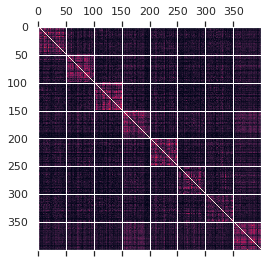

In [ ]:
sns.set(style="darkgrid")
plt.matshow(sim_df,aspect='equal')

**Onteniendo los sentimientos y categorías asociados a cada texto:**

In [ ]:
atributos_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/reviews_text_caract.csv")
atributos_df

,file,categoria,sentimiento
0,coches_no_1_11.txt,coches,no
1,coches_no_1_13.txt,coches,no
2,coches_no_1_15.txt,coches,no
3,coches_no_1_18.txt,coches,no
4,coches_no_1_19.txt,coches,no
...,...,...,...
395,peliculas_yes_5_23.txt,peliculas,yes
396,peliculas_yes_5_4.txt,peliculas,yes
397,peliculas_yes_5_5.txt,peliculas,yes
398,peliculas_yes_5_7.txt,peliculas,yes


In [ ]:
sentimientos = np.array(atributos_df["sentimiento"])
categorias = np.array(atributos_df["categoria"])

# Identificando sentimientos y categorias

## Con PCA

In [ ]:
trans_data = PCA(n_components=2).fit_transform(bow_estandar).T

trans_data_df = pd.DataFrame([trans_data[0],trans_data[1], sentimientos, categorias])

#fig = plt.figure(figsize=(15, 8))
#sns.scatterplota(trans_data_df, x = trans_data_df.com)
trans_data_df = trans_data_df.T
trans_data_df.columns = ["componente1", "componente2", "sentimiento", "categoria"]
trans_data_df.head()

,componente1,componente2,sentimiento,categoria
0,-5.80252,4.91164,no,coches
1,-1.80471,2.39497,no,coches
2,-3.83976,3.63862,no,coches
3,-5.15216,4.71529,no,coches
4,-4.51225,3.71516,no,coches


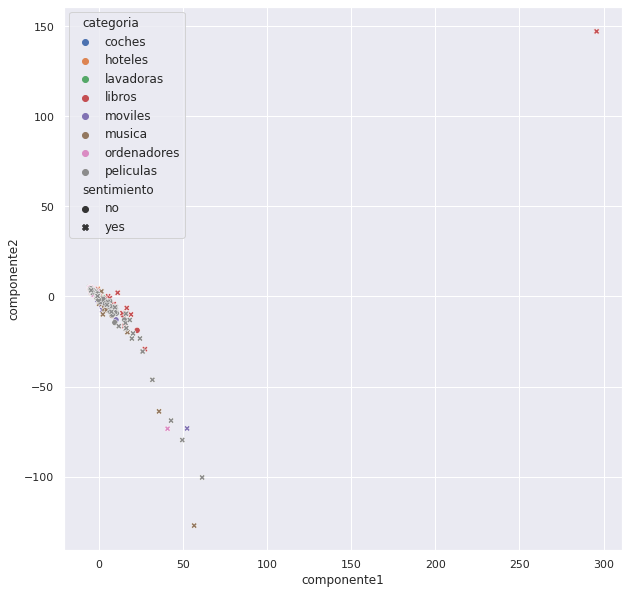

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=trans_data_df, x="componente1", y="componente2", style="sentimiento", hue="categoria")

## Con Kernel PCA

In [ ]:
trans_data = KernelPCA(n_components=5, kernel="cosine").fit_transform(bow_estandar).T

trans_data_df = pd.DataFrame([trans_data[0],trans_data[1], sentimientos, categorias])

#fig = plt.figure(figsize=(15, 8))
#sns.scatterplota(trans_data_df, x = trans_data_df.com)
trans_data_df = trans_data_df.T
trans_data_df.columns = ["componente1", "componente2", "sentimiento", "categoria"]
trans_data_df.head()

,componente1,componente2,sentimiento,categoria
0,-0.0814425,0.0125541,no,coches
1,0.0790603,0.0590169,no,coches
2,-0.00621159,0.020439,no,coches
3,-0.0980775,-0.0128946,no,coches
4,-0.0356937,0.0510482,no,coches


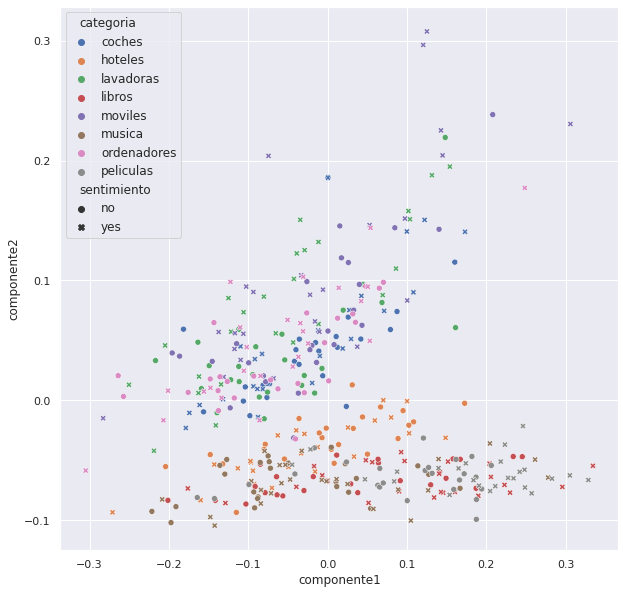

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=trans_data_df, x="componente1", y="componente2",
                style="sentimiento", hue="categoria")

## Con Spectral Embedding

In [ ]:
trans_data =  SpectralEmbedding(n_components=2,eigen_solver='arpack',
                                n_neighbors=5).fit_transform(bow).T

trans_data_df = pd.DataFrame([trans_data[0],trans_data[1], sentimientos, categorias])

#fig = plt.figure(figsize=(15, 8))
#sns.scatterplota(trans_data_df, x = trans_data_df.com)
trans_data_df = trans_data_df.T
trans_data_df.columns = ["componente1", "componente2", "sentimiento", "categoria"]
trans_data_df.head()

,componente1,componente2,sentimiento,categoria
0,0.00201792,-0.0283191,no,coches
1,0.00057272,-0.0318202,no,coches
2,0.00360154,-0.0312335,no,coches
3,0.00152912,-0.0378555,no,coches
4,0.00149665,-0.0375436,no,coches


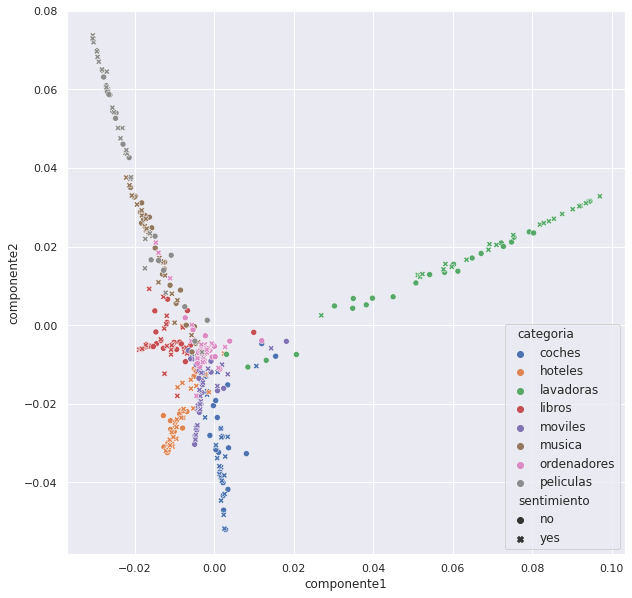

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=trans_data_df, x="componente1", y="componente2", style="sentimiento", hue="categoria")

## Con T-SNE

In [ ]:
trans_data =  TSNE(n_components=2, init='pca', random_state=0, perplexity=5)\
                .fit_transform(bow).T

trans_data_df = pd.DataFrame([trans_data[0],trans_data[1], sentimientos, categorias])

#fig = plt.figure(figsize=(15, 8))
#sns.scatterplota(trans_data_df, x = trans_data_df.com)
trans_data_df = trans_data_df.T
trans_data_df.columns = ["componente1", "componente2", "sentimiento", "categoria"]
trans_data_df.head()

,componente1,componente2,sentimiento,categoria
0,-28.7,23.3119,no,coches
1,-30.5331,21.9121,no,coches
2,-32.9651,29.7457,no,coches
3,-30.1177,26.306,no,coches
4,-28.6282,30.9575,no,coches


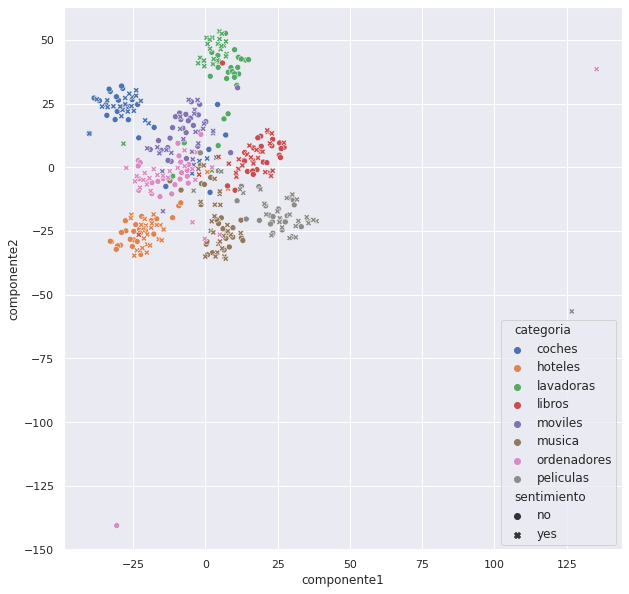

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=trans_data_df, x="componente1", y="componente2", style="sentimiento", hue="categoria")

# Clasificando textos por sentimiento:

Primero, separamos los textos en datos de entrenamiento y de prueba, con el fin de evaluar los modelos.

In [ ]:
bow_train, bow_test, sentimiento_train, sentimiento_test, categoria_train, categoria_test = train_test_split(bow,
                                                                     sentimientos,categorias,
                                                                     test_size = 0.2,
                                                                     random_state = 42)

## Con LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(bow_train, sentimiento_train)

In [ ]:
lda_predict = lda.predict(bow_test)
lda_predict

array(['no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes',
       'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes',
       'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no',
       'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes',
       'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no',
       'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no',
       'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no',
       'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no'],
      dtype='<U3')

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(sentimiento_test, lda_predict, digits=3))

              precision    recall  f1-score   support

          no      0.667     0.889     0.762        36
         yes      0.875     0.636     0.737        44

    accuracy                          0.750        80
   macro avg      0.771     0.763     0.749        80
weighted avg      0.781     0.750     0.748        80



**matriz de confusión**

In [ ]:
metrics.confusion_matrix(sentimiento_test, lda_predict)

array([[32,  4],
       [16, 28]])

## Con QDA

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(bow_train, sentimiento_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
qda_predict = qda.predict(bow_test)
qda_predict

array(['yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes',
       'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes',
       'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no',
       'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no'],
      dtype=object)

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(sentimiento_test, qda_predict, digits=3))

              precision    recall  f1-score   support

          no      0.516     0.444     0.478        36
         yes      0.592     0.659     0.624        44

    accuracy                          0.562        80
   macro avg      0.554     0.552     0.551        80
weighted avg      0.558     0.562     0.558        80



**matriz de confusión**

In [ ]:
metrics.confusion_matrix(sentimiento_test, qda_predict)

array([[16, 20],
       [15, 29]])

## Con Regresión Logística

In [ ]:
log_reg = linear_model.LogisticRegression(solver = 'sag', n_jobs=-1, max_iter=1000)
logistic_model = log_reg.fit(bow_train, sentimiento_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
logistic_predict = logistic_model.predict(bow_test)
logistic_predict

array(['yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes',
       'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no',
       'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes',
       'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes',
       'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes',
       'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no',
       'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes'],
      dtype=object)

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(sentimiento_test, logistic_predict, digits=3))

              precision    recall  f1-score   support

          no      0.595     0.694     0.641        36
         yes      0.711     0.614     0.659        44

    accuracy                          0.650        80
   macro avg      0.653     0.654     0.650        80
weighted avg      0.659     0.650     0.651        80



**matriz de confusión**

In [ ]:
metrics.confusion_matrix(sentimiento_test, logistic_predict)

array([[25, 11],
       [17, 27]])

# Clasificando textos por categoría:

## Con LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(bow_train, categoria_train)

In [ ]:
lda_predict = lda.predict(bow_test)
lda_predict

array(['moviles', 'musica', 'coches', 'moviles', 'hoteles', 'hoteles',
       'ordenadores', 'hoteles', 'musica', 'ordenadores', 'coches',
       'libros', 'hoteles', 'hoteles', 'lavadoras', 'musica', 'musica',
       'peliculas', 'moviles', 'peliculas', 'hoteles', 'coches',
       'ordenadores', 'musica', 'coches', 'peliculas', 'lavadoras',
       'moviles', 'musica', 'lavadoras', 'peliculas', 'libros', 'musica',
       'hoteles', 'moviles', 'lavadoras', 'lavadoras', 'ordenadores',
       'libros', 'lavadoras', 'peliculas', 'hoteles', 'hoteles',
       'moviles', 'hoteles', 'peliculas', 'lavadoras', 'libros', 'coches',
       'ordenadores', 'coches', 'ordenadores', 'ordenadores', 'hoteles',
       'libros', 'coches', 'moviles', 'libros', 'ordenadores', 'musica',
       'lavadoras', 'musica', 'musica', 'hoteles', 'lavadoras', 'coches',
       'ordenadores', 'musica', 'musica', 'hoteles', 'ordenadores',
       'lavadoras', 'coches', 'coches', 'libros', 'ordenadores',
       'ordenadores

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(categoria_test, lda_predict, digits=3))

              precision    recall  f1-score   support

      coches      1.000     0.769     0.870        13
     hoteles      1.000     1.000     1.000        13
   lavadoras      1.000     0.909     0.952        11
      libros      0.556     0.714     0.625         7
     moviles      0.857     0.750     0.800         8
      musica      0.769     1.000     0.870        10
 ordenadores      0.417     1.000     0.588         5
   peliculas      1.000     0.462     0.632        13

    accuracy                          0.812        80
   macro avg      0.825     0.826     0.792        80
weighted avg      0.882     0.812     0.818        80



## Con QDA

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(bow_train, categoria_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
qda_predict = qda.predict(bow_test)
qda_predict

array(['ordenadores', 'ordenadores', 'moviles', 'hoteles', 'ordenadores',
       'ordenadores', 'libros', 'musica', 'moviles', 'libros',
       'ordenadores', 'ordenadores', 'musica', 'libros', 'ordenadores',
       'hoteles', 'hoteles', 'lavadoras', 'ordenadores', 'musica',
       'libros', 'moviles', 'hoteles', 'musica', 'ordenadores', 'musica',
       'hoteles', 'libros', 'ordenadores', 'hoteles', 'lavadoras',
       'musica', 'libros', 'libros', 'ordenadores', 'libros', 'hoteles',
       'libros', 'libros', 'ordenadores', 'musica', 'ordenadores',
       'ordenadores', 'lavadoras', 'libros', 'musica', 'lavadoras',
       'musica', 'musica', 'libros', 'musica', 'ordenadores', 'moviles',
       'moviles', 'peliculas', 'musica', 'ordenadores', 'libros',
       'moviles', 'libros', 'libros', 'libros', 'libros', 'libros',
       'ordenadores', 'moviles', 'hoteles', 'lavadoras', 'musica',
       'lavadoras', 'ordenadores', 'libros', 'musica', 'ordenadores',
       'musica', 'libros', 'mus

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(categoria_test, qda_predict, digits=3))

              precision    recall  f1-score   support

      coches      0.000     0.000     0.000        13
     hoteles      0.000     0.000     0.000        13
   lavadoras      0.167     0.091     0.118        11
      libros      0.200     0.571     0.296         7
     moviles      0.000     0.000     0.000         8
      musica      0.062     0.100     0.077        10
 ordenadores      0.095     0.400     0.154         5
   peliculas      1.000     0.154     0.267        13

    accuracy                          0.125        80
   macro avg      0.191     0.165     0.114        80
weighted avg      0.217     0.125     0.105        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Con Regresión Logística

In [ ]:
log_reg = linear_model.LogisticRegression(solver = 'sag', n_jobs=-1, max_iter=1000)
logistic_model = log_reg.fit(bow_train, categoria_train)

In [ ]:
logistic_predict = logistic_model.predict(bow_test)
logistic_predict

array(['moviles', 'musica', 'coches', 'moviles', 'hoteles', 'hoteles',
       'ordenadores', 'hoteles', 'musica', 'lavadoras', 'coches',
       'libros', 'hoteles', 'hoteles', 'lavadoras', 'coches', 'musica',
       'peliculas', 'moviles', 'peliculas', 'hoteles', 'coches', 'musica',
       'musica', 'coches', 'peliculas', 'lavadoras', 'moviles', 'musica',
       'lavadoras', 'peliculas', 'libros', 'musica', 'hoteles', 'moviles',
       'lavadoras', 'lavadoras', 'ordenadores', 'libros', 'lavadoras',
       'peliculas', 'hoteles', 'hoteles', 'coches', 'hoteles',
       'peliculas', 'lavadoras', 'libros', 'coches', 'libros', 'coches',
       'ordenadores', 'ordenadores', 'hoteles', 'peliculas', 'coches',
       'moviles', 'libros', 'moviles', 'libros', 'lavadoras', 'musica',
       'musica', 'hoteles', 'lavadoras', 'coches', 'libros', 'musica',
       'libros', 'hoteles', 'ordenadores', 'lavadoras', 'coches',
       'coches', 'peliculas', 'moviles', 'moviles', 'libros', 'libros',
       '

**Midiendo la calidad del modelo**

In [ ]:
print(metrics.classification_report(categoria_test, logistic_predict, digits=3))

              precision    recall  f1-score   support

      coches      1.000     0.923     0.960        13
     hoteles      1.000     1.000     1.000        13
   lavadoras      1.000     1.000     1.000        11
      libros      0.636     1.000     0.778         7
     moviles      0.889     1.000     0.941         8
      musica      0.909     1.000     0.952        10
 ordenadores      1.000     1.000     1.000         5
   peliculas      1.000     0.615     0.762        13

    accuracy                          0.925        80
   macro avg      0.929     0.942     0.924        80
weighted avg      0.946     0.925     0.924        80



# Recuperando información

Con base en un texto (Query) de consulta, implementamos un método basado en la disimilaridad en el 
espacio de representación vectorial de los textos. Esta disimilaridad, la calculamos a partir del coseno de los
textos en $\mathbb{R}^{|V|}$; encontramos los cinco textos más cercanos del corpus y los mostramos por pantalla.

In [ ]:
query_ejemplo = "Los saltos con breves reflexiones, de lectura ágil y sin problemas de comprensión de una historia que se cuenta hacia atrás y en pequeñas dosis. Al libro le sobran páginas, divagaciones que no aportan demasiado, sin embargo me gustó bastante"

**vectorizamos el query**

In [ ]:
query_preprocesado = preprocesador.preprocesa(query_ejemplo)
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=10000)
vector = vectorizer.fit_transform([query_preprocesado])
#bow_ = X.toarray()
vector.toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
cos_sim = cosine_similarity(bow, bow)
sim_df = pd.DataFrame(cos_sim)
sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,1.000000,0.277635,0.253673,0.332779,0.280552,0.304335,0.198658,0.230956,0.253266,0.073898,0.379434,0.472360,0.238095,0.247076,0.330719,0.273388,0.184428,0.323502,0.337408,0.257172,0.128698,0.198471,0.258841,0.103457,0.109971,0.192879,0.325077,0.218218,0.246718,0.057864,0.064820,0.219873,0.223298,0.263963,0.177999,0.198471,0.185577,0.269771,0.333738,0.085724,...,0.029117,0.061644,0.034173,0.038432,0.000000,0.063719,0.047234,0.053121,0.040831,0.032410,0.043959,0.076680,0.070593,0.061314,0.093733,0.035098,0.055572,0.069418,0.016737,0.042593,0.032306,0.049471,0.053326,0.049249,0.049935,0.065542,0.030503,0.061454,0.059328,0.026963,0.073985,0.000000,0.037906,0.017556,0.000000,0.064880,0.046247,0.050152,0.038403,0.036960
1,0.277635,1.000000,0.241570,0.258695,0.201738,0.336676,0.168472,0.237627,0.186521,0.229786,0.305755,0.388863,0.175835,0.214937,0.275457,0.257268,0.164876,0.196009,0.245037,0.233240,0.231358,0.169716,0.231705,0.126383,0.101519,0.157437,0.182511,0.224164,0.237458,0.097461,0.117577,0.192290,0.148059,0.236768,0.149016,0.169716,0.208380,0.262142,0.250494,0.066640,...,0.096199,0.164728,0.132825,0.062740,0.022669,0.184377,0.126221,0.100657,0.152755,0.117577,0.115809,0.178828,0.178352,0.071496,0.127515,0.122779,0.128573,0.168636,0.068306,0.114384,0.078482,0.128906,0.121175,0.155876,0.106751,0.155401,0.203925,0.147534,0.096852,0.026201,0.143786,0.032580,0.105461,0.105769,0.065907,0.119786,0.125830,0.076892,0.135274,0.120672
2,0.253673,0.241570,1.000000,0.292505,0.261544,0.444800,0.269380,0.296728,0.213029,0.244072,0.433840,0.354830,0.177571,0.363524,0.327189,0.314271,0.255443,0.268638,0.297993,0.191799,0.248527,0.204408,0.238171,0.259818,0.109844,0.215774,0.250139,0.174371,0.378643,0.174674,0.103592,0.292824,0.244905,0.232558,0.240703,0.204408,0.252640,0.383228,0.243179,0.045666,...,0.144771,0.221662,0.136532,0.069609,0.051781,0.154634,0.119520,0.081358,0.152259,0.069061,0.104079,0.192895,0.137888,0.108876,0.139811,0.168274,0.135332,0.195684,0.066868,0.119639,0.114017,0.124938,0.085223,0.123683,0.115271,0.136170,0.162493,0.142504,0.103242,0.086182,0.128520,0.074420,0.053139,0.135609,0.124201,0.120969,0.163496,0.127647,0.144482,0.092538
3,0.332779,0.258695,0.292505,1.000000,0.284286,0.316294,0.239797,0.218365,0.195622,0.175585,0.420380,0.513698,0.266223,0.328887,0.385197,0.321775,0.064442,0.385657,0.477791,0.215666,0.247332,0.249658,0.268591,0.175585,0.172917,0.229145,0.353384,0.326783,0.303779,0.121312,0.135896,0.176704,0.192766,0.347649,0.220078,0.249658,0.244966,0.272315,0.431606,0.059907,...,0.115307,0.210012,0.083584,0.048344,0.040757,0.059372,0.103153,0.051044,0.067769,0.015100,0.064854,0.095265,0.049333,0.028566,0.085155,0.085847,0.109110,0.153620,0.052632,0.067650,0.073375,0.075547,0.088866,0.083585,0.101781,0.096187,0.091661,0.080840,0.113325,0.084793,0.128135,0.029288,0.041826,0.141091,0.059248,0.096349,0.111648,0.093462,0.097285,0.082652
4,0.280552,0.201738,0.261544,0.284286,1.000000,0.289641,0.340483,0.184094,0.157067,0.174150,0.398023,0.392427,0.238469,0.318861,0.296908,0.194978,0.119523,0.274679,0.371417,0.171717,0.123213,0.233862,0.434390,0.104490,0.121482,0.227273,0.329843,0.247947,0.252642,0.090909,0.114568,0.181356,0.177990,0.299069,0.258140,0.233862,0.145779,0.256066,0.332227,0.151515,...,0.065760,0.063557,0.023489,0.031700,0.034360,0.070910,0.073049,0.043033,0.036084,0.076379,0.060431,0.070275,0.048522,0.000000,0.016567,0.046526,0.109135,0.056235,0.049302,0.047907,0.038067,0.041021,0.048335,0.049741,0.076001,0.063715,0.052116,0.066023,0.044274,0.007943,0.051170,0.000000,0.056419,0.020687,0.000000,0.081227,0.096602,0.037755,0.066462,0.041373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## creando un corpus

In [ ]:
archivos= [open(mypath+filename, "r", encoding="latin-1") for filename in filenames]
corpus = [archivo.read() for archivo in archivos]
corpus.append(query_ejemplo) #añadimos el texto de consulta al vocabulario

## Preprocesando el corpus

In [ ]:
preprocesador = preprocesaTexto(idioma='es', _tokeniza=False, _muestraCambios=False, _quitarAcentos=True, _quitarNumeros=True,
                                _remueveStop=True, _stemming=False, _lematiza=True, _removerPuntuacion=True)

In [ ]:
corpus_prep = [preprocesador.preprocesa(txt) for txt in corpus]

## BOW

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=10000)
X = vectorizer.fit_transform(corpus_prep)
bow = X.toarray()
bow_estandar = StandardScaler().fit_transform(bow) 
bow_df = pd.DataFrame(bow,columns=vectorizer.get_feature_names())
bow_df

Dado que hay mucha información irrelevante, tomamos la más representativa. Nos quedamos con las palabras que tienen por lo menos 3 concurrencias en los 400 textos.

In [ ]:
frecuencias_por_palabra = bow_df.sum(axis=0)
frecuencias_por_palabra[frecuencias_por_palabra>6]

In [ ]:
palabras_relevantes = list(frecuencias_por_palabra[frecuencias_por_palabra>6].index)
palabras_relevantes

# Identificando disimilaridad en los textos con la disimilaridad del coseno

In [ ]:
# redefinimos la BOW
bow = bow_df[palabras_relevantes]
cos_sim = cosine_similarity(bow, bow)
sim_df = pd.DataFrame(cos_sim)
sim_df

**tomamos los textos que mayor similaridad tiene con el query en la entrada 401**

In [ ]:
similaridades_query = np.array(sim_df.iloc[400])
similaridades_query[:5]

In [ ]:
top6 = similaridades_query.argsort()[-6:][::-1] #top 6 textos más parecidos

In [ ]:
top5 = top6[1:]
top5

In [ ]:
i = 1
for rank_ix in top5:
    
    print(f" --------------top {i} texto más parecido al query-------------\n{corpus[rank_ix]}")
    i += 1
    

# Neural Network Model Selection

In [ ]:
parameters = [
  {'hidden_layer_sizes': [[10,],[10,10], [10,2], [10,5]], 'alpha': [0.1, 0.5, 1, 5]}
]
mlp = MLPClassifier(solver='lbfgs', random_state=0)
GS = GridSearchCV(estimator=mlp, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,categorias)

KeyboardInterrupt: ignored

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.9724999999999999
Best estimator: MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[10], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


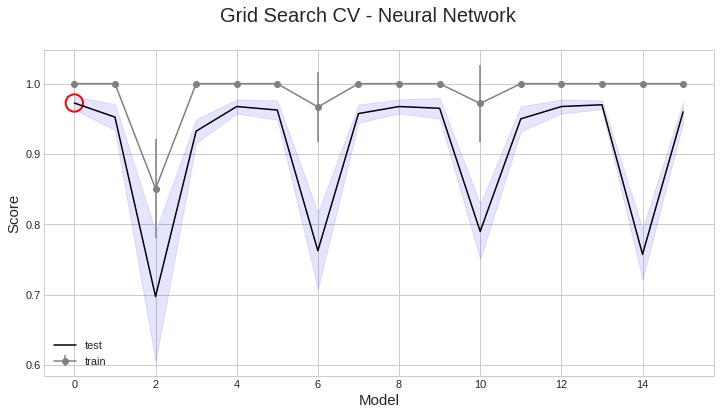

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Neural Network',size=20)
plt.legend(loc="best")
plt.show()

# Support Vector Machine Model Selection

In [ ]:
parameters = [
    {'kernel': ['linear'], "C":[0.5, 1]},
    {'kernel':['rbf'], 'gamma': [.1, 10], 'C': [0.5, 1]}
]
svm = SVC()
GS = GridSearchCV(estimator=svm, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,categorias)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.5, 1], 'kernel': ['linear']},
                         {'C': [0.5, 1], 'gamma': [0.1, 10],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.9525
Best estimator: SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


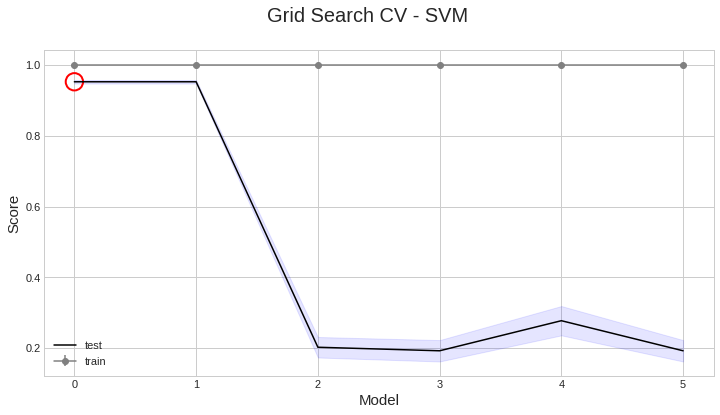

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - SVM',size=20)
plt.legend(loc="best")
plt.show()

# Decision Tree Model Selection

In [ ]:
parameters = [
    {'max_depth': [2,4,6], "ccp_alpha":[0.01, 0.1, 1, 10]}
]
ctree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(estimator=ctree, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,categorias)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.01, 0.1, 1, 10],
                          'max_depth': [2, 4, 6]}],
             pre_d

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.745
Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


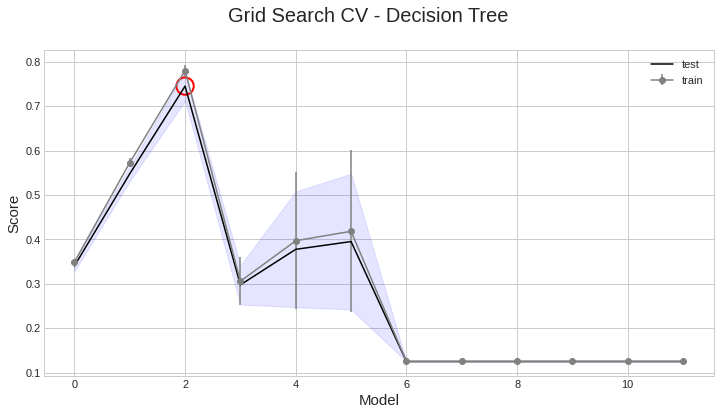

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Decision Tree',size=20)
plt.legend(loc="best")
plt.show()

# Ada Boost

In [ ]:
parameters = [
    {'n_estimators': [50,100,500,1000], "learning_rate":[ 0.1, 1, 1.5, 10]}
]
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME")
GS = GridSearchCV(estimator=ada_classifier, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,categorias)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
      

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.8925000000000001
Best estimator: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         pre

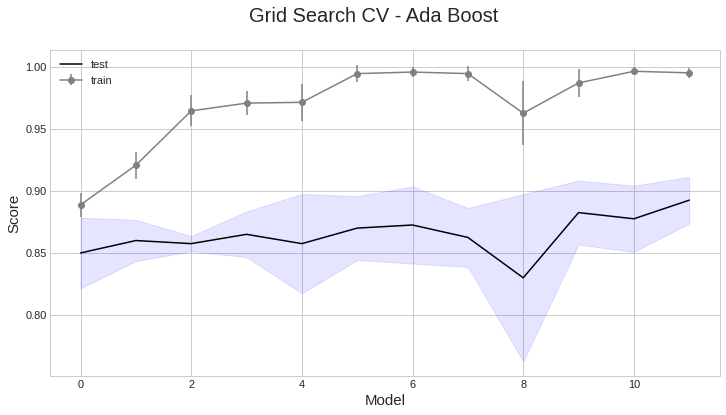

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Ada Boost',size=20)
plt.legend(loc="best")
plt.show()

# Análisis por sentimientos

# Neural Network Model Selection

In [ ]:
parameters = [
  {'hidden_layer_sizes': [[10,],[10,10], [10,2], [10,5]], 'alpha': [0.1, 0.5, 1, 5]}
]
mlp = MLPClassifier(solver='lbfgs', random_state=0)
GS = GridSearchCV(estimator=mlp, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,sentimientos)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=0, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'a

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.6725
Best estimator: MLPClassifier(activation='relu', alpha=0.5, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[10, 2], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


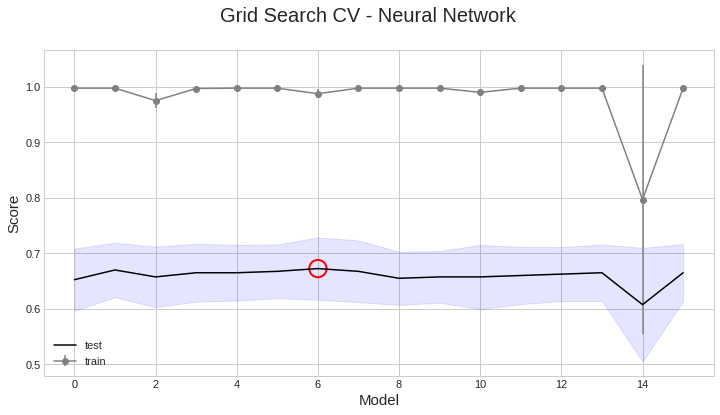

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Neural Network',size=20)
plt.legend(loc="best")
plt.show()

# Support Vector Machine Model Selection

In [ ]:
parameters = [
    {'kernel': ['linear'], "C":[0.5, 1]},
    {'kernel':['rbf'], 'gamma': [.1, 10], 'C': [0.5, 1]}
]
svm = SVC()
GS = GridSearchCV(estimator=svm, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,sentimientos)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.5, 1], 'kernel': ['linear']},
                         {'C': [0.5, 1], 'gamma': [0.1, 10],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.6525000000000001
Best estimator: SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


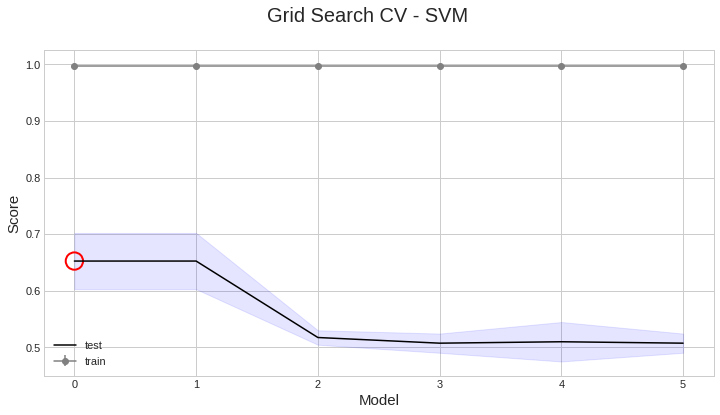

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - SVM',size=20)
plt.legend(loc="best")
plt.show()

# Decision Tree Model Selection

In [ ]:
parameters = [
    {'max_depth': [2,4,6], "ccp_alpha":[0.01, 0.1, 1, 10]}
]
ctree = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(estimator=ctree, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,sentimientos)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.01, 0.1, 1, 10],
                          'max_depth': [2, 4, 6]}],
             pre_d

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.6
Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


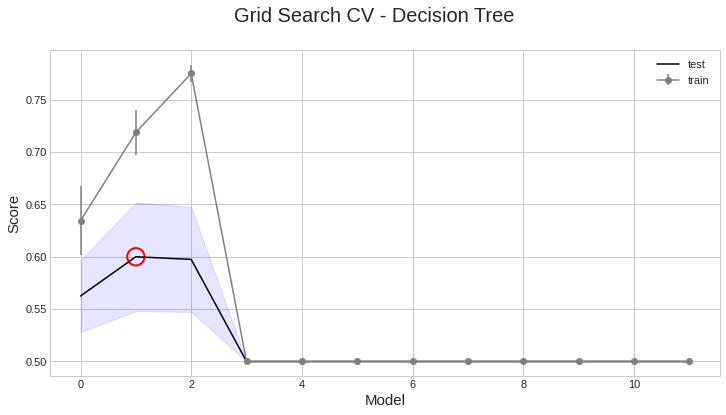

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Decision Tree',size=20)
plt.legend(loc="best")
plt.show()

# Ada Boost

In [ ]:
parameters = [
    {'n_estimators': [50,100,500,1000], "learning_rate":[ 0.1, 1, 1.5, 10]}
]
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME")
GS = GridSearchCV(estimator=ada_classifier, param_grid=parameters, cv = 5, return_train_score=True, n_jobs=-1)
GS.fit(bow,sentimientos)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
      

In [ ]:
print('Best score:', GS.best_score_) 
print('Best estimator:',GS.best_estimator_) 

Best score: 0.655
Best estimator: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='depreca

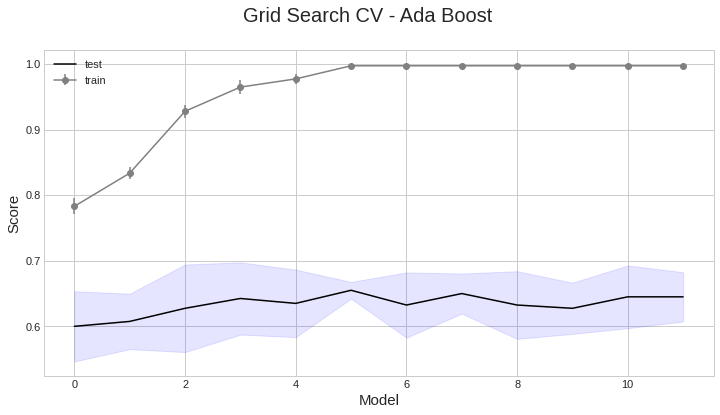

In [ ]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Model',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV - Ada Boost',size=20)
plt.legend(loc="best")
plt.show()